##### Pacotes Necessários 

In [527]:
# Descomente as linhas desta célula para instalar os pacotes necessários
# !pip3 install xgboost
# !pip3 install psycopg2
# !pip3 install pandas
# !pip3 install configparser
# !pip3 install scikit-learn
# !pip3 install matplotlib
# !pip3 install numpy

In [528]:
import psycopg2
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from configparser import ConfigParser


##### Conexão com a Base e Extração de Dados

In [529]:
# Função para configuração de conexão com parâmetros de acesso presentes no arquivo database.ini
# Transforma o arquivo em uma variável de objeto
def config(filename='database.ini', section='postgresql'):
    
    parser = ConfigParser()
    parser.read(filename)

    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
        print('Configurações carregadas.')
    else:
        raise Exception('Seção {0} não encontrada no arquivo {1}'.format(section, filename))
    return db

In [530]:
def connect():
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        cursor = conn.cursor()

        retorno = []

        cursor.execute('SELECT * FROM forms')
        forms = cursor.fetchall()
        cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'forms'")
        colunas = cursor.fetchall()
        retorno.append([forms, colunas])

        cursor.execute('SELECT * FROM orders')
        orders = cursor.fetchall()
        cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'orders'")
        colunas = cursor.fetchall()
        retorno.append([orders, colunas])

        cursor.execute('SELECT * FROM order_items')
        items = cursor.fetchall()
        cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'order_items'")
        colunas = cursor.fetchall()
        retorno.append([items, colunas])

        cursor.close()
        return retorno
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Conexão encerrada.')


if __name__ == '__main__':
    retorno = connect()

Configurações carregadas.
Conexão encerrada.


In [531]:
# Atribuindo bases de dados a variáveis
forms = pd.DataFrame(retorno[0][0])
forms.columns = [item for sublist in retorno[0][1] for item in sublist]

orders = pd.DataFrame(retorno[1][0])
orders.columns = [item for sublist in retorno[1][1] for item in sublist]

order_items = pd.DataFrame(retorno[2][0])
order_items.columns = [item for sublist in retorno[2][1] for item in sublist]

##### Manipulação de dados

In [532]:
# Remoção de colunas
forms = forms.drop(['id_cliente','data','sistema_operacional','navegador','localizacao','locale','cidade','utm_source',
'caracteristica','tempo_procedimento','efeitos_desejados','estado','procedimentos'], axis = 1)

orders = orders[['id_pedido','target']]

order_items = order_items[['id_pedido','id_form']]

In [533]:
# Selecionando apenas os valores únicos da coluna 'id_form' da tabela 'order_items'
items_form = order_items.drop_duplicates(subset = ['id_form'])
# Left join da tabela 'forms' com a 'items_form' seguido de left join da tabela resultante com a tabela 'orders'. 
# df é a base de dados resultante
df = forms.merge(items_form, 
                 on = 'id_form', 
                 how = 'left').merge(orders, 
                                     on = 'id_pedido', 
                                     how = 'left').drop(['id_form','id_pedido'], axis = 1)

In [534]:
# Lidando com NAs
df.target.fillna(0, inplace = True)
df.dropna(axis = 0, inplace = True)


In [535]:
# Transformação de variáveis
[df.tipo_cabelo, codes_tipo_cabelo] = pd.factorize(df.tipo_cabelo, sort = True)
[df.comprimento, codes_comprimento] = pd.factorize(df.comprimento, sort = True)
[df.tipo_fios, codes_tipo_fios] = pd.factorize(df.tipo_fios, sort = True)
[df.dieta, codes_dieta] = pd.factorize(df.dieta, sort = True)
[df.atividade_fisica, codes_atividade_fisica] = pd.factorize(df.atividade_fisica, sort = True)
[df.frequencia_estresse, codes_frequencia_estresse] = pd.factorize(df.frequencia_estresse, sort = True)
[df.faixa_etaria, codes_faixa_etaria] = pd.factorize(df.faixa_etaria, sort = True)
[df.fragancia, codes_fragancia] = pd.factorize(df.fragancia, sort = True)

In [536]:
# Divisão entre features e variável alvo
y = df.pop('target')
X = df.copy()

# Divisão do conjunto em dados de treino e de teste (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [ ]:
# Treinamento e predição do modelo
model = xgb.XGBClassifier(random_state = 9, 
                                max_depth = 12,
                                n_estimators = 400,
                                learning_rate = 1.2,
                                subsample = 0.2,
                                )
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,y_train, verbose = False, eval_metric=["error", "logloss"], eval_set=eval_set)
preds = model.predict(X_test)

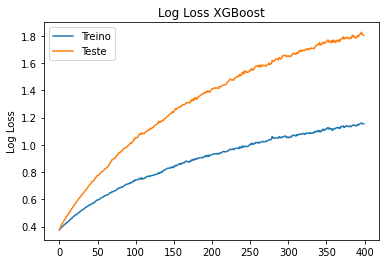

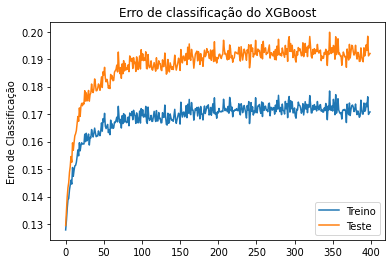

In [538]:
# Plotando os erros dos conjuntos de treino e teste
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Treino')
ax.plot(x_axis, results['validation_1']['logloss'], label='Teste')
ax.legend()
plt.ylabel('Log Loss')
plt.title('Log Loss XGBoost')
plt.show()
# Plot erro classificação
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Treino')
ax.plot(x_axis, results['validation_1']['error'], label='Teste')
ax.legend()
plt.ylabel('Erro de Classificação')
plt.title('Erro de classificação do XGBoost')
plt.show()

Text(0.5, 0, 'Taxa de Falsos Positivos')

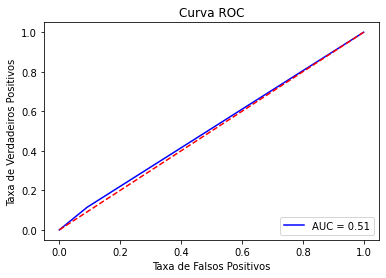

In [539]:
# Curva ROC
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')

In [540]:
# Eficácia no conjunto de teste
accuracy_score(y_test,preds)

0.8079136970829925

In [541]:
x = pd.DataFrame([y_test.reset_index(drop = True),preds]).T
obs = y_test[y_test == 1]
eficacia_positivos = x[(x['target'] == 1) & (x['Unnamed 0'] == 1)].shape[0]/obs.shape[0]
print('A eficácia atingida nos casos positivos do conjunto de teste foi de {0}%'.format(np.round(np.amax(eficacia_positivos)*100),2) )

A eficácia atingida nos casos positivos do conjunto de teste foi de 11.0%


In [ ]:
# Validação cruzada
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold)

In [543]:
print('A acurácia máxima atingida através da validação cruzada por K-fold foi de {0}%'.format(np.round(np.amax(results)*100),2) )

A acurácia máxima atingida através da validação cruzada por K-fold foi de 81.0%


In [544]:
model.save_model('model.json')